In [ ]:
#!pip install Kaggle

In [ ]:
from google.colab import files
import os 

In [ ]:
# remove (if exists) the folder: kaggle
!rm -r ~/.kaggle
# make the folder: kaggle
!mkdir ~/.kaggle
files.upload()
# move kaggle.json file in kaggle folder
!mv ./kaggle.json ~/.kaggle/
# giving read and write access
!chmod 600 ~/.kaggle/kaggle.json

rm: cannot remove '/root/.kaggle': No such file or directory


Saving kaggle.json to kaggle.json


In [ ]:
#!kaggle datasets download meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
!kaggle datasets download jorisonkaggle/gtsrb-final-training-dataset
#! unzip gtsrb-final-training-dataset.zip -d GTSRB
! unzip gtsrb-final-training-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: GTSRB/Final_Training/Images/00035/00000_00019.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00000_00020.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00000_00021.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00000_00022.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00000_00023.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00000_00024.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00000_00025.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00000_00026.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00000_00027.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00000_00028.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00000_00029.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00001_00000.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00001_00001.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00001_00002.ppm  
  inflating: GTSRB/Final_Training/Image

In [ ]:
import matplotlib.pyplot as plt
import glob
from skimage.color import rgb2lab
from skimage.transform import resize
from collections import namedtuple
import numpy as np
np.random.seed(101)
%matplotlib inline

In [ ]:
N_CLASSES = 43 # number of classes
RESIZED_IMAGE = (32, 32) # size of images after being resized

First write a function that reads all the images given in a path

In [ ]:
def to_tf_format(imgs):
  return np.stack([img[:,:, np.newaxis] for img in imgs], axis=0).astype(np.float32)

Then **resize** them to a predifined shape, convert them to grayscale, and also **one-hot encode** label.


The name encode, literally means “convert to [computer] code”.


One-hot encoding is the representation of categorical variables as binary vectors.


In order to do that we will use a named tuple dataset


In [ ]:
Dataset = namedtuple("Dataset", ["X","y"])

In [ ]:
rootpath = "GTSRB/Final_Training/Images"

In [ ]:
images = []
lables = []

In [ ]:
for c in range(N_CLASSES):
  full_path = rootpath + '/' +format(c, '05d')+'/'
  for img_name in glob.glob(full_path + "*.ppm"):
    img = plt.imread(img_name).astype(np.float32)
    img = rgb2lab(img/225.0)[:, :, 0]
    img = resize(img, RESIZED_IMAGE, mode='reflect')
    lable = np.zeros((N_CLASSES, ), dtype=np.float32)
    lable[c] = 1.0
    images.append(img.astype(np.float32))
    lables.append(lable)

In [ ]:
dataset = Dataset(X = to_tf_format(images).astype(np.float32),y = np.matrix(lables).astype(np.float32))

In [ ]:
print(dataset.X.shape)
print(dataset.y.shape)

(39209, 32, 32, 1)
(39209, 43)


Note:

The **shape** of the observation matrix X has four dimentions. The first indexes the observations (in this case we have almost 40,000 of them). The other 3 dimentions contain the image (which is 32*32 pixels grayscale, that is one dimentional). This is the default shape when dealing with images in Tensorflow.

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


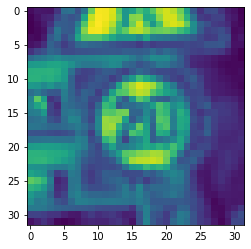

In [ ]:
plt.imshow(dataset.X[0,:,:].reshape(RESIZED_IMAGE)) #sample
print(dataset.y[0,:]) # lable

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


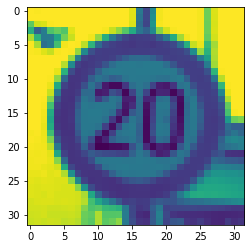

In [ ]:
plt.imshow(dataset.X[1,:,:].reshape(RESIZED_IMAGE)) #sample
print(dataset.y[1,:]) # lable

You can see that the image, that is the feature vectore, is 32*32. the lable contains only one 1 in the first position.

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


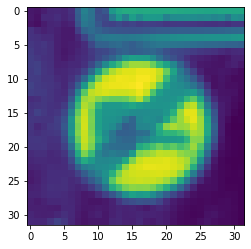

In [ ]:
# print last sample
plt.imshow(dataset.X[-1, :, :, :].reshape(RESIZED_IMAGE)) # sample 
print(dataset.y[-1, :]) # lable

The **shapes** are crucial in deep learning while working with images; in contrast to classical machine learning observation matrices, here the X has four dimentions!

The last step of our preprocessing is the **train/test split**. In this example, we will use 75% for training and 25% for testing.We want to train our model on a subset of the dataset, and then measure the perfomance on the leftover samples, that is, the test set. To do so, let's use the function provided by sklearn:

In [ ]:
range(dataset.X.shape[0])


range(0, 39209)

In [ ]:
from sklearn.model_selection import train_test_split
idx_train, idx_test = train_test_split(range(dataset.X.shape[0]), test_size=0.25, random_state=101)
X_train = dataset.X[idx_train, :, :, :]
X_test = dataset.X[idx_test, :, :, :]
y_train = dataset.y[idx_train, :]
y_test = dataset.y[idx_test, :]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(29406, 32, 32, 1)
(29406, 43)
(9803, 32, 32, 1)
(9803, 43)


The first thing to have is a function to creat **minibatches** of training data. In fact, at each training iteration, we would need to insert a minibatch of samples extracted from the traning set. Here we will build a function that takes the observations, lables, and the batch size as arguments and returns a minibatch generator. Furthuremore, to introduce some variability in the trainig data, let's add another argument to the function, the possibility to **shuffle** the data to have different minibatches of data for each generator. Having different minibatches of data in each generator will force the model to learn the in-out connection and not memorize the sequence: 

In [ ]:
def minibatcher(X, y, batch_size, shuffle):
  assert X.shape[0] == y.shape[0]
  n_samples = X.shape[0]
  
  if shuffle:
    idx = np.random.permutation(n_samples)
  else:
    idx = list(range(n_samples))
  
  for k in range(int(np.ceil(n_samples/batch_size))):
    from_idx = k*batch_size
    to_idx = (k+1)*batch_size
    yield X[idx[from_idx:to_idx], :, :, :], y[idx[from_idx:to_idx], :]

To test this function, let's print the shapes of minibaches while imposing batch_size=10000:

In [ ]:
for mb in minibatcher(X_train, y_train, 10000, True):
  print(mb[0].shape, mb[1].shape)

(10000, 32, 32, 1) (10000, 43)
(10000, 32, 32, 1) (10000, 43)
(9406, 32, 32, 1) (9406, 43)


The 29,406 samples in the trianing set are split into two minibatches of 10,000 elements. The same number of elements are in the lable matrix too.

**Building model:**

first build the blocks that will compose the network. We can start creating the fully connected layer with a variable *number of units* (it's an argument), without activation. We've decided to use Xavier initialization for the coefficients (weights) and o- initialization for the biases to have the layer centered and scaled properly. The output is simply the multiplication of the input tensor by the weights, which defined dynamically, the therfore can be used anywhere in the network:

In [ ]:
import tensorflow as tf
print(tf. __version__) 

2.9.2


In [ ]:
def fc_no_activation_layer(in_tensors, n_units):
  w = tf.compat.v1.get_variable('fc_W', 
    [in_tensors.get_shape()[1], n_units],
    tf.compat.v1.float32,
    tf.compat.v1.keras.initializers.glorot_normal)
  b = tf.compat.v1.get_variable('fc_B',
    [n_units, ],
    tf.compat.v1.float32,
    tf.compat.v1.constant_initializer(0.0))
  return tf.matmul(in_tensors, w) + b

Let's now creat the fully connected layer with activation; specifically, here we will use the leaky ReLU. As you can see, we can build this function using the previous one:

In [ ]:
def fc_layer(in_tensors, n_units):
  return tf.nn.leaky_relu(fc_no_activation_layer(in_tensors, n_units))

Finally let's creat a convolutional layer that takes as arguments the input data, kernetl size, and number of filters(or units). We will use the same activations used in the fully connected layer. In this case, the output passes through leaky RelU activation:

In [ ]:
def conv_layer(in_tensors, kernel_size, n_units):
  w = tf.compat.v1.get_variable('conv_W', 
    [kernel_size, kernel_size, in_tensors.get_shape()[3], n_units],
    tf.float32,
    tf.compat.v1.keras.initializers.glorot_normal)
  b = tf.compat.v1.get_variable('conv_B',
    [n_units, ],
    tf.float32,
    tf.constant_initializer(0.0))
  return tf.nn.leaky_relu(tf.nn.conv2d(in_tensors, w, [1, 1, 1, 1], 'SAME') + b)


Now we creat a maxpool_layer. Here, the size of the window and the strides are both squares (quadrates):

In [ ]:
def maxpool_layer(in_tensors, sampling):
  return tf.nn.max_pool(in_tensors, [1, sampling, sampling, 1], [1, sampling, sampling, 1], 'SAME')


The last thing to define is the dropout, used for regularization the network. Pretty simple thing to creat, but remember that dropout should onlky be used when trainig the network, and not when predicting the outputs; therfore, we need to have a conditional operator to define whether to apply dropouts or not:

In [ ]:
def dropout(in_tensors, keep_proba, is_training):
  return tf.cond(is_training, lambda: tf.nn.dropout(in_tensors, keep_proba), lambda: in_tensors)


Finally, it's time to put it all together and creat the model as previously defined. We'll creat a model composed of the following layers:


1.   2D convolution, 5x5, 32 filters
2.   2D convolution, 5x5, 64 filters
3.   Flattenizer
4.   Fully connected layer, 1024 units
5.   Dropout 40%
6.   Fully connected layer, no activation
7.   Sogtmax output

Here's the code:

In [ ]:
def model(in_tensors, is_training):
  
  # First layer: 5x5 2d-conv, 32 filters, 2x maxpool, 20% drouput
  with tf.compat.v1.variable_scope('l1'):
    l1 = maxpool_layer(conv_layer(in_tensors, 5, 32), 2)
    l1_out = dropout(l1, 0.8, is_training)
  
  # Second layer: 5x5 2d-conv, 64 filters, 2x maxpool, 20% drouput
  with tf.compat.v1.variable_scope('l2'):
    l2 = maxpool_layer(conv_layer(l1_out, 5, 64), 2)
    l2_out = dropout(l2, 0.8, is_training)
    
  with tf.compat.v1.variable_scope('flatten'):
    l2_out_flat = tf.compat.v1.layers.flatten(l2_out)
  
  # Fully collected layer, 1024 neurons, 40% dropout 
  with tf.compat.v1.variable_scope('l3'):
    l3 = fc_layer(l2_out_flat, 1024)
    l3_out = dropout(l3, 0.6, is_training)
  
  # Output
  with tf.compat.v1.variable_scope('out'):
    out_tensors = fc_no_activation_layer(l3_out, N_CLASSES)
  
  return out_tensors

And now, let's write the function to train the model on the training set and test the performance on the test set. Please note that all of the following code belongs to the function t rain_model function; it's broken down in to pieces just for simplicity of explanation. 

The function takes as arguments (other than the training and test sets and their labels) the learning rate, the number of epochs, and the batch size, that is, number of images per training batch. First things first, some TensorFlow placeholders are defined: one for the minibatch of images, one for the minibatch of labels, and the last one to select whether to run for training or not (that's mainly used by the dropout layer): 


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

def train_model(X_train, y_train, X_test, y_test, learning_rate, max_epochs, batch_size):

  in_X_tensors_batch = tf.compat.v1.placeholder(tf.float32, shape = (None, RESIZED_IMAGE[0], RESIZED_IMAGE[1], 1))
  in_y_tensors_batch = tf.compat.v1.placeholder(tf.float32, shape = (None, N_CLASSES))
  is_training = tf.compat.v1.placeholder(tf.bool)

  # Now, let's define the output, metric score and optimizer. 
  # Here, we decided to use the AdamOptimizer and the cross entropy with softmax(logits) as loss:
  logits = model(in_X_tensors_batch, is_training)
  out_y_pred = tf.nn.softmax(logits)
  loss_score = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=in_y_tensors_batch)
  loss = tf.reduce_mean(loss_score)
  optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate).minimize(loss)
  
  # code for training the model with minibatches:
  with tf.compat.v1.Session() as session:
    session.run(tf.compat.v1.global_variables_initializer())

    for epoch in range(max_epochs):
      print("Epoch=", epoch)
      tf_score = []
        
      for mb in minibatcher(X_train, y_train, batch_size, shuffle = True):
        tf_output = session.run([optimizer, loss], 
                                feed_dict = {in_X_tensors_batch : mb[0], 
                                              in_y_tensors_batch : mb[1],
                                              is_training : True})
      
        tf_score.append(tf_output[1])
      print(" train_loss_score=", np.mean(tf_score))
    # after the training is done, time to test it on the test set
    print("TEST SET PERFORMANCE")
    y_test_pred, test_loss  = session.run([out_y_pred, loss], 
                                          feed_dict = {in_X_tensors_batch : X_test, 
                                                       in_y_tensors_batch : y_test,
                                                       is_training : False})
    # print the classification report and plot the confusion matrix (and its log2 version) to see the misclassifications:
    print(" test_loss_score=", test_loss)
    y_test_pred_classified = np.argmax(y_test_pred, axis=1).astype(np.int32)
    y_test_true_classified = np.argmax(y_test, axis=1).astype(np.int32)
    print(classification_report(y_test_true_classified, y_test_pred_classified))
    
    cm = confusion_matrix(y_test_true_classified, y_test_pred_classified)
    
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    plt.tight_layout()
    plt.show()
    
    # And the log2 version, to enphasize the misclassifications
    plt.imshow(np.log2(cm + 1), interpolation='nearest', cmap=plt.get_cmap("tab20"))
    plt.colorbar()
    plt.tight_layout()
    plt.show()



In [ ]:
tf.compat.v1.disable_eager_execution()

<ipython-input-20-a524bfd72b0b>:14: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
  l2_out_flat = tf.compat.v1.layers.flatten(l2_out)


Epoch= 0
 train_loss_score= 13.281285
Epoch= 1
 train_loss_score= 4.1014752
Epoch= 2
 train_loss_score= 3.266271
Epoch= 3
 train_loss_score= 2.6473093
Epoch= 4
 train_loss_score= 2.160485
Epoch= 5
 train_loss_score= 1.8143308
Epoch= 6
 train_loss_score= 1.5933508
Epoch= 7
 train_loss_score= 1.396562
Epoch= 8
 train_loss_score= 1.2797676
Epoch= 9
 train_loss_score= 1.1682389
TEST SET PERFORMANCE
 test_loss_score= 0.43367654
              precision    recall  f1-score   support

           0       1.00      0.54      0.70        67
           1       0.88      0.81      0.84       539
           2       0.82      0.81      0.82       558
           3       0.96      0.44      0.60       364
           4       0.76      0.97      0.85       487
           5       0.63      0.75      0.69       479
           6       0.98      0.96      0.97       105
           7       0.59      0.88      0.71       364
           8       0.78      0.57      0.66       340
           9       0.97      0.9

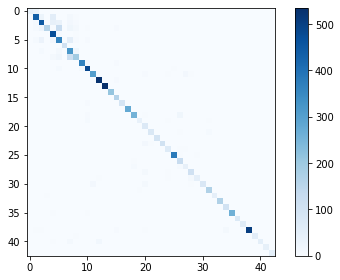

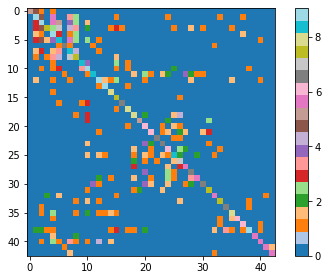

In [ ]:
tf.compat.v1.reset_default_graph()
# train model
train_model(X_train, y_train, X_test, y_test, 0.001, 10, 256)
